<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0710.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_100_acc(y_true, y_pred):
    delta = 100
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_300_acc(y_true, y_pred):
    delta = 300
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))
 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 7.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=cb94d5a3b09b8cfbae365344bb1de2063890b13cac8ea739fdd8f4c8c8f166de
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Using TensorFlow backend.


In [2]:
per_meter_mapping = {
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
}

per_room_additional_price = {
    'Mercaz': 15. * 10**4,
    'Old North': 8. * 10**4,
    'Florentine': 5. * 10**4
}

per_type_price = {
    'fullsize': 3,
    'economy': 1.2,
    'convertible': 9,
    'standard': 2.5,
    'premium': 4,
    'intermediate': 2,
    'luxury': 12,
    'compact': 1.5
}

def house_price_func(row):
    """
    house_price_func is the function f(a,s,n).
    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    area, size, n_rooms, ctype = row['area'], row['size'], row['n_rooms'], row['ctype']
    return (size * per_meter_mapping[area] - 120) + (n_rooms*n_rooms)/4 * per_room_additional_price[area] * per_type_price[ctype]

In [3]:
AREAS = ['Mercaz', 'Old North', 'Florentine']
HOUSE_TYPE = ['economy','compact','intermediate','standard','fullsize','premium','luxury','convertible']

def create_samples(n_samples):
    """
    Helper method that creates dataset DataFrames
    
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame
    """
    samples = []

    for i in range(n_samples):
        samples.append([np.random.choice(AREAS), int(np.random.normal(25, 5)),int(np.random.normal(300, 50)), np.random.choice(range(1, 6)),np.random.choice(HOUSE_TYPE)])
        
    return pd.DataFrame(samples, columns=['area', 'size', 'lamp', 'n_rooms','ctype'])

In [4]:
dataset = create_samples(n_samples=30000)
dataset['price'] = dataset.apply(house_price_func, axis=1)

In [5]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,int64,30000,0,24.4527,5.00853,5,21,24,28,46,NaN,NaN,NaN
lamp,int64,30000,0,299.045,50.0219,116,265,299,333,525,NaN,NaN,NaN
n_rooms,int64,30000,0,2.9991,1.41203,1,2,3,4,5,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.14135e+06,1.71716e+06,16260,175760,503905,1.3554e+06,1.12684e+07,NaN,NaN,NaN


In [6]:
# dataset의 파생변수 생성

dataset['size_n_rooms'] = dataset['size'] * dataset['n_rooms']
dataset['size_size'] = dataset['size'] * dataset['size']
dataset['n_rooms_n_rooms'] = dataset['n_rooms'] * dataset['n_rooms']

In [7]:
# zscore norm

ds = dataset[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms
0,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094
1,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840
2,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840
3,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149
4,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900
...,...,...,...,...,...,...,...,...,...
29995,Old North,1.107578,0.678800,0.708837,intermediate,650380.0,1.212522,1.118778,0.580094
29996,Florentine,-0.090379,0.978669,-1.415762,intermediate,30400.0,-1.286119,-0.189911,-1.156149
29997,Florentine,0.708259,0.998660,0.708837,standard,506320.0,1.004302,0.650235,0.580094
29998,Florentine,2.505195,-0.560658,0.708837,fullsize,608390.0,1.941292,3.013147,0.580094


In [8]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [9]:
area_mapping = EmbeddingMapping(dataset['area'])
type_mapping = EmbeddingMapping(dataset['ctype'])

dataset = dataset.assign(area_mapping=dataset['area'].apply(area_mapping.get_mapping))
dataset = dataset.assign(type_mapping=dataset['ctype'].apply(type_mapping.get_mapping))
dataset

,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping
0,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1
1,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2
2,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2
3,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3
4,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4
...,...,...,...,...,...,...,...,...,...,...,...
29995,Old North,1.107578,0.678800,0.708837,intermediate,650380.0,1.212522,1.118778,0.580094,2,5
29996,Florentine,-0.090379,0.978669,-1.415762,intermediate,30400.0,-1.286119,-0.189911,-1.156149,1,5
29997,Florentine,0.708259,0.998660,0.708837,standard,506320.0,1.004302,0.650235,0.580094,1,3
29998,Florentine,2.505195,-0.560658,0.708837,fullsize,608390.0,1.941292,3.013147,0.580094,1,4


In [10]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms','area_mapping','type_mapping']],
    dataset['price'], test_size=0.1, random_state=0)


X_train_continuous_org = X_train_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_train_categorical_org = X_train_org[['area_mapping','type_mapping']]
X_val_continuous_org = X_val_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_val_categorical_org = X_val_org[['area_mapping','type_mapping']]

# 학습 대상 변수만 선택
X_train_continuous = X_train_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_train_categorical = X_train_categorical_org
X_val_continuous  = X_val_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_val_categorical = X_val_categorical_org


In [11]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3
input_dim = X_train_categorical['area_mapping'].max()* X_train_categorical['type_mapping'].max() + 1
print('input_dim:',input_dim)
# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)
print(cate_embedings)
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

input_dim: 25
Tensor("reshape_1/Reshape:0", shape=(None, 144), dtype=float32)


In [12]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2, 72)        1800        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 144)          0           embedding_1[0][0]                
____________________________________________________________________________________________

In [13]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 37197.022567708336, 'val_soft_100_acc': 0.649228036403656, 'val_soft_300_acc': 0.9163876175880432, 'val_r2': 1.0, 'loss': 35469.54262384259, 'soft_100_acc': 0.62597007, 'soft_300_acc': 0.91800207, 'r2': 1.0}
Epoch: 100 - {'val_loss': 24116.704544270833, 'val_soft_100_acc': 0.7190290093421936, 'val_soft_300_acc': 0.9445684552192688, 'val_r2': 1.0, 'loss': 22545.021045717593, 'soft_100_acc': 0.7203446, 'soft_300_acc': 0.9491903, 'r2': 1.0}
Epoch: 150 - {'val_loss': 20101.2217421875, 'val_soft_100_acc': 0.7521856427192688, 'val_soft_300_acc': 0.9540085792541504, 'val_r2': 1.0, 'loss': 18442.887705439814, 'soft_100_acc': 0.75815314, 'soft_300_acc': 0.9586172, 'r2': 1.0}
Epoch: 200 - {'val_loss': 18131.869565104167, 'val_soft_100_acc': 0.7679036259651184, 'val_soft_300_acc': 0.958565890789032, 'val_r2': 1.0, 'loss': 16373.623913773148, 'soft_100_acc': 0.78086245, 'soft_300_acc': 0.9636355, 'r2': 1.0}
Epoch: 250 - {'val_loss': 16693.468065104167, 'val_soft_100_acc': 

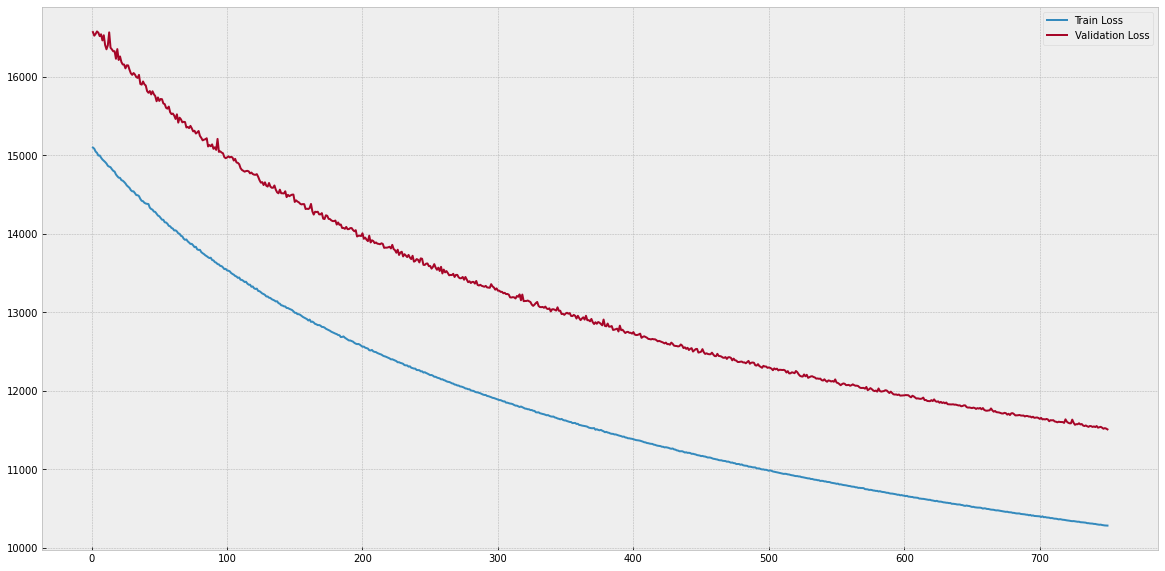

In [14]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1128773
          price           pred         diff     abs_diff     %diff  abs_%diff
6655    39980.0   38251.988281 -1728.011719  1728.011719 -4.322190   4.322190
22304  113630.0  114636.593750  1006.593750  1006.593750  0.885852   0.885852
23494   33430.0   34436.539062  1006.539062  1006.539062  3.010886   3.010886
7663    52180.0   53128.734375   948.734375   948.734375  1.818195   1.818195
15928   33660.0   34432.238281   772.238281   772.238281  2.294231   2.294231
The mean is very close to 0 (-1.6) with std. 107.28.


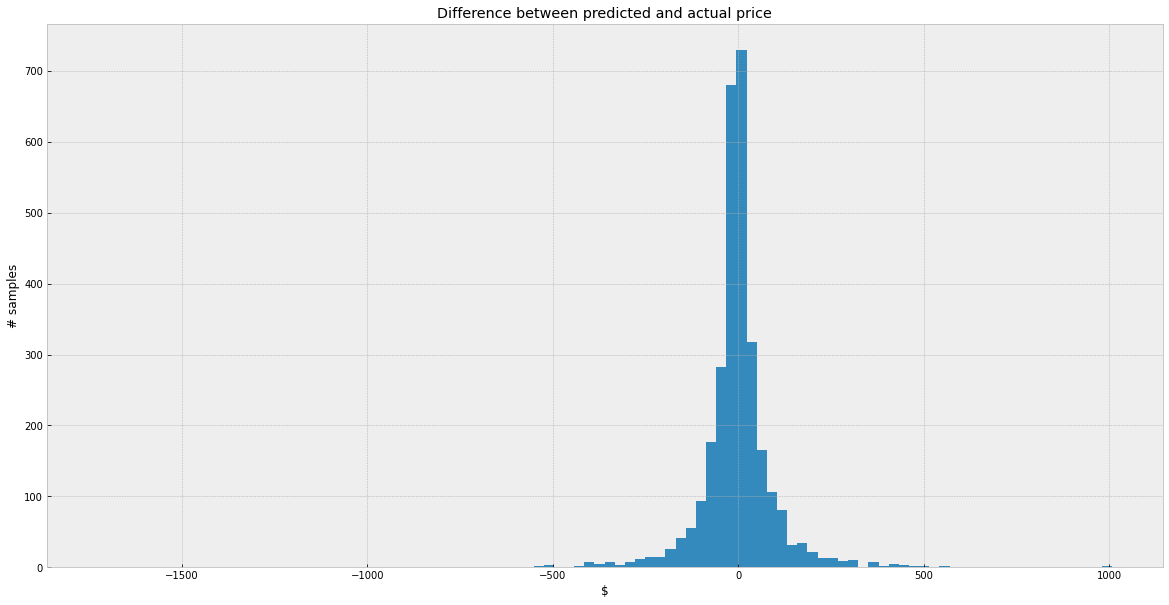

In [15]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
print(df.sort_values("abs_diff", ascending=False).head(5))
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

         price          pred         diff     abs_diff     %diff  abs_%diff
6655   39980.0  38251.988281 -1728.011719  1728.011719 -4.322190   4.322190
23494  33430.0  34436.539062  1006.539062  1006.539062  3.010886   3.010886
15928  33660.0  34432.238281   772.238281   772.238281  2.294231   2.294231
21596  28780.0  29371.302734   591.302734   591.302734  2.054561   2.054561
7663   52180.0  53128.734375   948.734375   948.734375  1.818195   1.818195


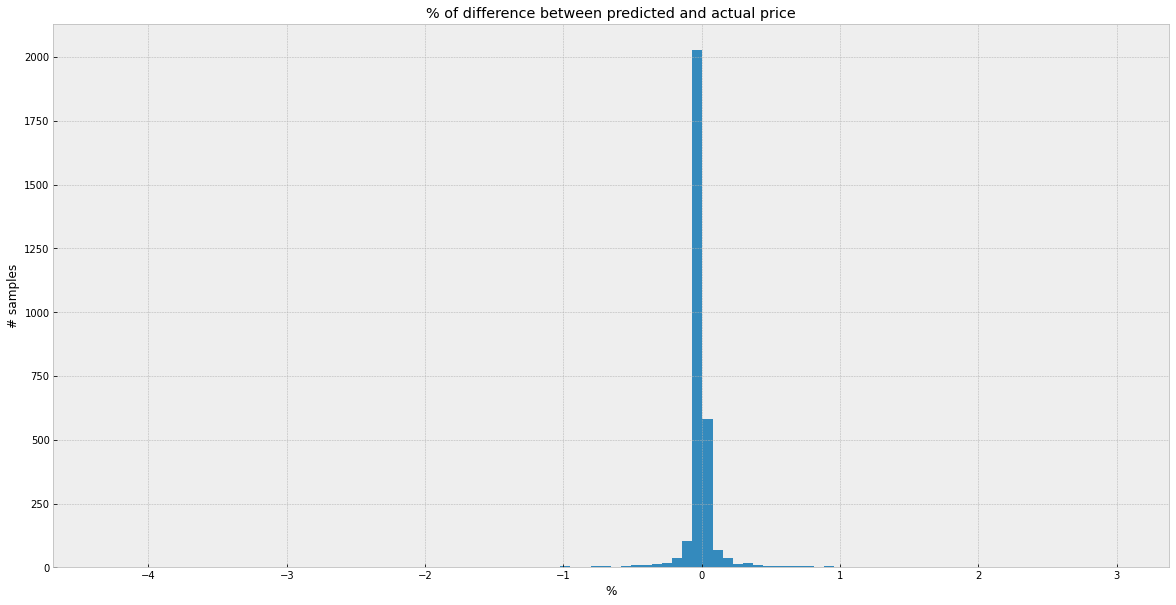

In [16]:
# Sort by the '%diff' field and show the 5 largest proportional mistakes
print(df.sort_values("abs_%diff", ascending=False).head(5))

# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df['%diff'], bins=100)
plt.xlabel("%")
plt.ylabel("# samples")
_ = plt.title("% of difference between predicted and actual price")

In [17]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['price'],
    mode="regression"
)

In [18]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'] )

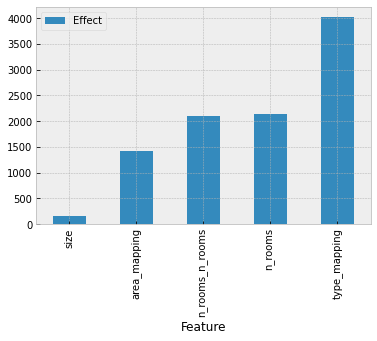

In [19]:
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect',kind='bar')

In [20]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.14135e+06,1.71716e+06,16260,175760,503905,1.3554e+06,1.12684e+07,NaN,NaN,NaN
size_n_rooms,float64,30000,0,1.23106e-16,1,-1.78064,-0.817624,-0.114881,0.744027,3.81527,NaN,NaN,NaN
size_size,float64,30000,0,2.33831e-17,1,-2.41549,-0.735198,-0.189911,0.650235,6.0304,NaN,NaN,NaN
n_rooms_n_rooms,float64,30000,0,8.1335e-16,1,-1.15615,-0.8089,-0.230153,0.580094,1.62184,NaN,NaN,NaN
area_mapping,int64,30000,0,2.00173,0.816957,1,1,2,3,3,NaN,NaN,NaN


In [21]:
dataset_area_mapping = pd.DataFrame(to_categorical(dataset['area_mapping']-1),columns=['area_' + s for s in AREAS])
dataset_type_mapping = pd.DataFrame(to_categorical(dataset['type_mapping']-1),columns=['type_' + s for s in HOUSE_TYPE])
dataset = pd.concat([dataset,dataset_area_mapping,dataset_type_mapping], axis=1)

In [22]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.14135e+06,1.71716e+06,16260,175760,503905,1.3554e+06,1.12684e+07,NaN,NaN,NaN
size_n_rooms,float64,30000,0,1.23106e-16,1,-1.78064,-0.817624,-0.114881,0.744027,3.81527,NaN,NaN,NaN
size_size,float64,30000,0,2.33831e-17,1,-2.41549,-0.735198,-0.189911,0.650235,6.0304,NaN,NaN,NaN
n_rooms_n_rooms,float64,30000,0,8.1335e-16,1,-1.15615,-0.8089,-0.230153,0.580094,1.62184,NaN,NaN,NaN
area_mapping,int64,30000,0,2.00173,0.816957,1,1,2,3,3,NaN,NaN,NaN


In [23]:
dataset

,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible
0,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Old North,1.107578,0.678800,0.708837,intermediate,650380.0,1.212522,1.118778,0.580094,2,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29996,Florentine,-0.090379,0.978669,-1.415762,intermediate,30400.0,-1.286119,-0.189911,-1.156149,1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29997,Florentine,0.708259,0.998660,0.708837,standard,506320.0,1.004302,0.650235,0.580094,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29998,Florentine,2.505195,-0.560658,0.708837,fullsize,608390.0,1.941292,3.013147,0.580094,1,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
#  추가 파생변수 생성
dataset_size_area_mapping = dataset[['area_' + s for s in AREAS]].multiply(dataset['size'], axis=0)
dataset_n_rooms_area_mapping = dataset[['area_' + s for s in AREAS]].multiply(dataset['n_rooms'], axis=0)
dataset_size_area_mapping.rename(columns={'area_' + s:'size_area_'+s for s in AREAS}, inplace=True)
dataset_n_rooms_area_mapping.rename(columns={'area_' + s:'n_rooms_area_'+s for s in AREAS}, inplace=True)

dataset_size_type_mapping = dataset[['type_' + s for s in HOUSE_TYPE]].multiply(dataset['size'], axis=0)
dataset_n_rooms_type_mapping = dataset[['type_' + s for s in HOUSE_TYPE]].multiply(dataset['n_rooms'], axis=0)
dataset_size_type_mapping.rename(columns={'type_' + s:'size_type_'+s for s in HOUSE_TYPE}, inplace=True)
dataset_n_rooms_type_mapping.rename(columns={'type_' + s:'n_rooms_type_'+s for s in HOUSE_TYPE}, inplace=True)

In [25]:
dataset = pd.concat([dataset,dataset_size_area_mapping,dataset_n_rooms_area_mapping,dataset_size_type_mapping,dataset_n_rooms_type_mapping], axis=1)

In [26]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.14135e+06,1.71716e+06,16260,175760,503905,1.3554e+06,1.12684e+07,NaN,NaN,NaN
size_n_rooms,float64,30000,0,1.23106e-16,1,-1.78064,-0.817624,-0.114881,0.744027,3.81527,NaN,NaN,NaN
size_size,float64,30000,0,2.33831e-17,1,-2.41549,-0.735198,-0.189911,0.650235,6.0304,NaN,NaN,NaN
n_rooms_n_rooms,float64,30000,0,8.1335e-16,1,-1.15615,-0.8089,-0.230153,0.580094,1.62184,NaN,NaN,NaN
area_mapping,int64,30000,0,2.00173,0.816957,1,1,2,3,3,NaN,NaN,NaN


In [27]:
dataset

,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
0,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.889017,-0.000000,-0.000000,0.708837,0.000000,0.000000,-0.889017,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,0.708837,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.290039,-0.000000,0.000000,1.417037,0.000000,-0.000000,-0.290039,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,0.000000,1.417037,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.105876,0.000000,0.000000,1.417037,0.000000,0.000000,0.000000,2.105876,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.417037,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.689358,-0.000000,-0.000000,-1.415762,-0.000000,-0.000000,-0.000000,-0.689358,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-1.415762,-0.000000,-0.000000,-0.000000,-0.0,-0.0
4,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.000000,-0.689358,-0.000000,-0.000000,-0.707562,-0.000000,-0.000000,-0.000000,-0.000000,-0.689358,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.707562,-0.000000,-0.000000,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Old North,1.107578,0.678800,0.708837,intermediate,650380.0,1.212522,1.118778,0.580094,2,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.107578,0.000000,0.000000,0.708837,0.000000,0.000000,0.000000,0.000000,0.000000,1.107578,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.708837,0.000000,0.0,0.0
29996,Florentine,-0.090379,0.978669,-1.415762,intermediate,30400.0,-1.286119,-0.189911,-1.156149,1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.090379,-0.000000,-0.000000,-1.415762,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.090379,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-1.415762,-0.000000,-0.0,-0.0
29997,Florentine,0.708259,0.998660,0.708837,standard,506320.0,1.004302,0.650235,0.580094,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.708259,0.000000,0.000000,0.708837,0.000000,0.000000,0.000000,0.000000,0.708259,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.708837,0.000000,0.000000,0.000000,0.0,0.0
29998,Florentine,2.505195,-0.560658,0.708837,fullsize,608390.0,1.941292,3.013147,0.580094,1,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.505195,0.000000,0.000000,0.708837,0.000000,0.000000,0.000000,0.000000,0.000000,2.505195,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.708837,0.000000,0.000000,0.0,0.0


In [28]:
# trainset과 validationset 나누고... 기타 정리

columns = list(dataset.columns)
for a in ['area','ctype','lamp','price','size_n_rooms','size_size']:
  columns.remove(a)

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[columns],
    dataset['price'], test_size=0.1, random_state=0)

columns.remove('area_mapping')
columns.remove('type_mapping')

X_train_continuous = X_train_org[columns]
X_train_categorical = X_train_org[['area_mapping','type_mapping']]
X_val_continuous = X_val_org[columns]
X_val_categorical = X_val_org[['area_mapping','type_mapping']]


In [29]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3
input_dim = X_train_categorical['area_mapping'].max()* X_train_categorical['type_mapping'].max() + 1
print('input_dim:',input_dim)
# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

print(all_input)

input_dim: 25
Tensor("concatenate_2/concat:0", shape=(None, 180), dtype=float32)


In [30]:
 def mean_squared_error(y_true, y_pred):
     return K.mean(K.square(y_pred - y_true), axis=-1)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1,)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss=mean_squared_error, optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 2, 72)        1800        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 144)          0           embedding_2[0][0]                
____________________________________________________________________________________________

In [31]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous,X_train_categorical], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous,X_val_categorical], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 11394.250208333333, 'val_soft_100_acc': 0.8586774468421936, 'val_soft_300_acc': 0.9776785373687744, 'val_r2': 1.0, 'loss': 11595.973802372686, 'soft_100_acc': 0.8643266, 'soft_300_acc': 0.9821534, 'r2': 1.0}
Epoch: 100 - {'val_loss': 7602.9794140625, 'val_soft_100_acc': 0.9073195457458496, 'val_soft_300_acc': 0.9825613498687744, 'val_r2': 1.0, 'loss': 7828.369537760416, 'soft_100_acc': 0.9080742, 'soft_300_acc': 0.9865941, 'r2': 1.0}
Epoch: 150 - {'val_loss': 6387.967348958334, 'val_soft_100_acc': 0.9243397116661072, 'val_soft_300_acc': 0.9848399758338928, 'val_r2': 1.0, 'loss': 6428.963782262732, 'soft_100_acc': 0.92559, 'soft_300_acc': 0.9888848, 'r2': 1.0}
Epoch: 200 - {'val_loss': 5720.489571614583, 'val_soft_100_acc': 0.933779776096344, 'val_soft_300_acc': 0.9864675998687744, 'val_r2': 1.0, 'loss': 5689.54838035301, 'soft_100_acc': 0.93344444, 'soft_300_acc': 0.989961, 'r2': 1.0}
Epoch: 250 - {'val_loss': 5208.275278645833, 'val_soft_100_acc': 0.9344308376

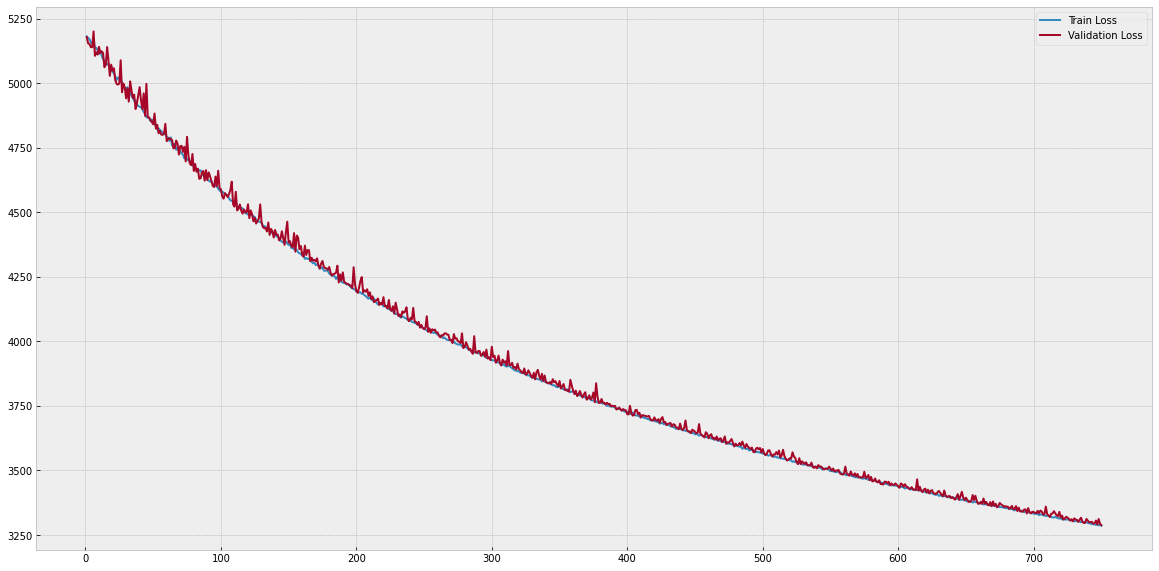

In [32]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1128773
The mean is very close to 0 (0.19) with std. 57.35.


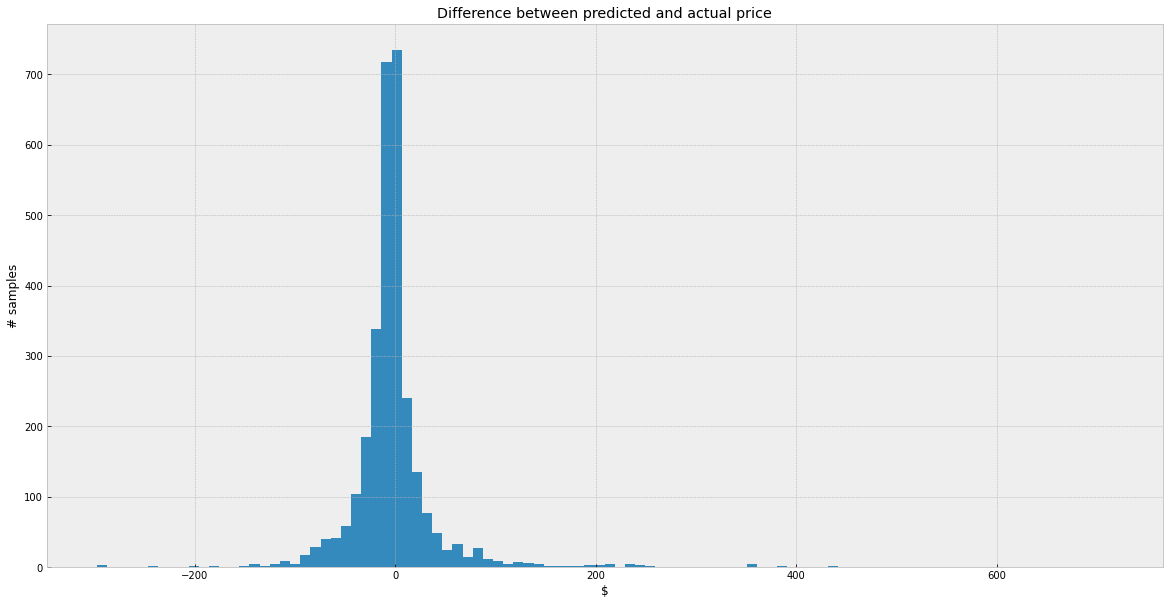

,pred,diff,abs_diff,%diff,abs_%diff,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
22304,1.143450e+05,715.007812,715.007812,0.629242,0.629242,Mercaz,3.104174,-0.140842,-1.415762,standard,113630.0,-0.869679,3.946194,-1.156149,3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.104174,-0.000000,-0.000000,-1.415762,0.0,0.000000,3.104174,0.000000,0.000000,0.0,0.000000,0.000000,-0.0,-0.000000,-1.415762,-0.000000,-0.000000,-0.0,-0.000000,-0.000000
12944,4.710572e+05,677.218750,677.218750,0.143973,0.143973,Mercaz,3.303833,0.718782,-0.707562,fullsize,470380.0,0.223477,4.273367,-0.808900,3,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.303833,-0.000000,-0.000000,-0.707562,0.0,0.000000,0.000000,3.303833,0.000000,0.0,0.000000,0.000000,-0.0,-0.000000,-0.000000,-0.707562,-0.000000,-0.0,-0.000000,-0.000000
18143,5.144828e+04,568.281250,568.281250,1.116905,1.116905,Mercaz,-2.486294,-2.079994,-1.415762,economy,50880.0,-1.598449,-1.934830,-1.156149,3,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,-2.486294,-0.000000,-0.000000,-1.415762,-0.0,-2.486294,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-1.415762,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000
834,7.242555e+05,525.500000,525.500000,0.072610,0.072610,Old North,-2.685953,-0.300772,-0.707562,convertible,723730.0,-1.338174,-2.027731,-0.808900,2,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.000000,-2.685953,-0.000000,-0.000000,-0.707562,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-2.685953,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.707562,-0.000000
29145,1.809596e+06,516.375000,516.375000,0.028544,0.028544,Florentine,3.104174,-0.880518,0.708837,convertible,1809080.0,2.253622,3.946194,0.580094,1,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.104174,0.000000,0.000000,0.708837,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.104174,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.708837,0.000000
28712,4.633378e+05,507.750000,507.750000,0.109706,0.109706,Old North,2.505195,-0.600641,0.000637,standard,462830.0,0.978274,3.013147,-0.230153,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.505195,0.000000,0.000000,0.000637,0.000000,0.0,0.000000,2.505195,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000637,0.000000,0.000000,0.0,0.000000,0.000000
5886,1.019868e+06,488.187500,488.187500,0.047891,0.047891,Mercaz,-2.086975,-1.340317,0.000637,fullsize,1019380.0,-0.817624,-1.724794,-0.230153,3,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,-2.086975,0.000000,0.000000,0.000637,-0.0,-0.000000,-0.000000,-2.086975,-0.000000,-0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,0.000637,0.000000,0.0,0.000000,0.000000
775,1.254201e+06,471.000000,471.000000,0.037568,0.037568,Old North,-2.685953,0.278975,1.417037,standard,1253730.0,-0.479266,-2.027731,1.621840,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-2.685953,-0.000000,0.000000,1.417037,0.000000,-0.0,-0.000000,-2.685953,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,0.0,0.000000,1.417037,0.000000,0.000000,0.0,0.000000,0.000000
3392,2.406332e+06,452.500000,452.500000,0.018808,0.018808,Mercaz,-2.486294,0.318957,0.708837,premium,2405880.0,-0.661459,-1.934830,0.580094,3,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.000000,-0.00000

In [33]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['price'],inplace=True)
b = a.join(dataset)
b.head(10)

In [34]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['price'],
    mode="regression"
)

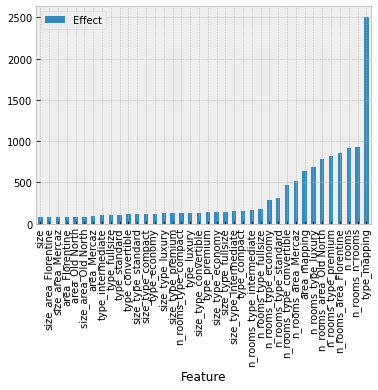

,Feature,Effect
0,size,75.438779
1,size_area_Florentine,78.888391
2,size_area_Mercaz,79.687750
3,area_Florentine,80.800419
4,area_Old North,81.093038
5,size_area_Old North,81.998638
6,area_Mercaz,93.720782
7,type_intermediate,102.709771
8,type_fullsize,104.133400
9,type_standard,110.859153


In [35]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect',kind='bar')
plt.show()
effect_result_table